# Loop Detection
## Of long (>1 minute) Samples

In [1]:
import os
import pretty_midi
from midi_player import MIDIPlayer
from midi_player.stylers import dark

midi_file = os.path.join("data", "inputs", "MIDI1.mid")
midi_data = pretty_midi.PrettyMIDI(midi_file)
piano_roll = midi_data.get_piano_roll()

notes = []
for instrument in midi_data.instruments:
    # Don't include drum instruments
    if not instrument.is_drum:
        for note in instrument.notes:
            notes.append(
                (note.start, note.end, note.pitch, note.velocity)
            )  # TODO use pm Note object

MIDIPlayer(midi_file, 400, styler=dark)

## Chroma SSM

In [2]:
import ssm_utils
import numpy as np

sr = 2

chroma = midi_data.get_chroma(sr)
ssm_chroma = np.dot(np.transpose(chroma), chroma)
novelty_curve = ssm_utils.compute_novelty_ssm(ssm_chroma, L=1, exclude=True)
boundary = ssm_utils.get_boundaries(novelty_curve, np.array(range(0, chroma.shape[1])))

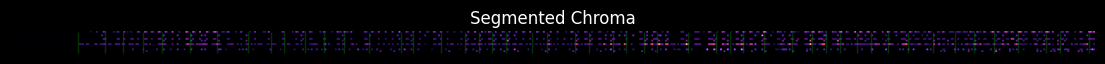

In [3]:
from matplotlib import pyplot as plt

plt.style.use("dark_background")

plt.figure(figsize=(14, 10))
plt.imshow(chroma / chroma.max(), cmap="magma")
plt.vlines(boundary[1], 0, 12, "g", linewidth=1, alpha=0.4)
# plt.plot(
#     (1 - novelty_curve / novelty_curve.max()) * ssm_pr.shape[0],
#     "g",
#     linewidth=1,
#     alpha=0.4,
# )
plt.title("Segmented Chroma")
plt.axis("off")
plt.show()

## Segment the MIDI

In [4]:
segmented_midi = ssm_utils.boundary_split_t(notes, boundary[0] / sr)
len(segmented_midi.keys())

52

In [5]:
import matplotlib.patches as patches
from pathlib import Path

for i, (k, bin) in enumerate(segmented_midi.items()):
    segment = pretty_midi.PrettyMIDI(initial_tempo=midi_data.estimate_tempo())
    piano_program = pretty_midi.instrument_name_to_program("Acoustic Grand Piano")
    piano = pretty_midi.Instrument(program=piano_program)

    for note in bin:
        piano.notes.append(pretty_midi.Note(note[3], note[2], note[0], note[1]))
        # rect = patches.Rectangle(
        #     (note[0], note[2]), note[1] - note[0], 1, color="white"
        # )

    segment.instruments.append(piano)

    dir_out = os.path.join("data", "outputs", f"{Path(midi_file).stem}")
    if not os.path.exists(dir_out):
        os.makedirs(dir_out)
    segment.write(
        os.path.join(
            "data",
            "outputs",
            f"{Path(midi_file).stem}",
            f"{Path(midi_file).stem}-{i}.mid",
        )
    )
#         ax.add_patch(rect)

# ax.set_xlabel("Time (seconds)")
# ax.set_ylabel("MIDI Note Number")
# ax.set_title("Piano Roll")

# plt.ylim(20, 108)  # MIDI note range for a piano
# plt.xlim(
#     20, max(notes[:20], key=lambda x: x[1])[1]
# )  # Set x-axis limits to the duration of the longest note
# # plt.grid(True)
# plt.show()

ValueError: data byte must be in range 0..127